# Team 3 - Datathon Final Attempt - Churn Prediction

## Introduction

PowerCo is a major utility company in Spain that both gas and electricity services for Corporate, SMEs and Residential clients. Recent liberalization of the energy market in Europe inducing a more intense competition between energy providers. Moreover, PowerCo is experiencing ani ncreasing customer defection well above industry average. The aim of this notebook is to leverage customer data in the SME department to identify potential churners in the upcoming 3-month peried and use customer insights to develop recommendations that are going to reduce the churn rate.

## Churn Prediction

### Environment setup and Train Data import

In [1]:
# importing necessary libarbies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, plot_confusion_matrix, \
confusion_matrix, f1_score, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import RandomOverSampler, BorderlineSMOTE, SMOTE
import xgboost
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Our team is provided with several training datasets regarding the customer data. The first dataset contains customer information regarding their contract details, energy consumption, origination and many more.

In [2]:
# importing and preparing train SME dataset
df1 = pd.read_csv('Training_SME_data.csv', index_col='id', parse_dates = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'])

# deleting columns:
# unnamed: 0 - incorrect csv file reading
# campaign_disc_ele - the majority of values is null
# date_first_activ - identical to date_activ but with a lot more null values
df1 = df1.drop(columns=['Unnamed: 0', 'campaign_disc_ele', 'date_first_activ'])

# visual display
df1.head()

FileNotFoundError: ignored

The second dataset provides monthly pricing information in 2015 for each PowerCo customer.

In [ ]:
# importing and preparing price dataset 
df2 = pd.read_csv('Training_PRICE_hist.csv', index_col='id')

# adding percentage change of price for each month
df2['price_p1_change_v'] = df2['price_p1_var'].pct_change()
df2['price_p2_change_v'] = df2['price_p2_var'].pct_change()
df2['price_p3_change_v'] = df2['price_p3_var'].pct_change()
df2['price_p1_change_f'] = df2['price_p1_fix'].pct_change()
df2['price_p2_change_f'] = df2['price_p2_fix'].pct_change()
df2['price_p3_change_f'] = df2['price_p3_fix'].pct_change()

# getting rid of inappropriate values: infinit and big ints (ids are going one after the other). 
# N/A imputation is also not ruining the mean estimates in the analysis further below
df2.loc[df2['price_p1_change_f']>1, 'price_p1_change_f'] = np.nan
df2.loc[df2['price_p1_change_v']>1, 'price_p1_change_v'] = np.nan

# visual display
df2.head()

,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,price_p1_change_v,price_p2_change_v,price_p3_change_v,price_p1_change_f,price_p2_change_f,price_p3_change_f
id,,,,,,,,,,,,,
038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.000000,NaN,NaN,0.0,NaN,NaN
038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.000000,NaN,NaN,0.0,NaN,NaN
038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0,-0.011502,NaN,NaN,0.0,NaN,NaN
038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0,0.000000,NaN,NaN,0.0,NaN,NaN


In [ ]:
# verifying the format based on the randomly chosen id with infinit values prior correction
df2.loc[df2.index == 'b5bebc0e9f98984f387814f74fc47b0f'].head()

,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,price_p1_change_v,price_p2_change_v,price_p3_change_v,price_p1_change_f,price_p2_change_f,price_p3_change_f
id,,,,,,,,,,,,,
b5bebc0e9f98984f387814f74fc47b0f,2015-01-01,0.170156,0.085569,0.0,44.266931,0.0,0.0,NaN,inf,NaN,NaN,NaN,NaN
b5bebc0e9f98984f387814f74fc47b0f,2015-02-01,0.170590,0.087658,0.0,44.266931,0.0,0.0,0.002551,0.024413,NaN,0.0,NaN,NaN
b5bebc0e9f98984f387814f74fc47b0f,2015-03-01,0.170590,0.087658,0.0,44.266931,0.0,0.0,0.000000,0.000000,NaN,0.0,NaN,NaN
b5bebc0e9f98984f387814f74fc47b0f,2015-04-01,0.170590,0.087658,0.0,44.266931,0.0,0.0,0.000000,0.000000,NaN,0.0,NaN,NaN
b5bebc0e9f98984f387814f74fc47b0f,2015-05-01,0.170590,0.087658,0.0,44.266931,0.0,0.0,0.000000,0.000000,NaN,0.0,NaN,NaN


In [ ]:
# identifying null values after adding new variables
df2.isnull().sum()

price_date                0
price_p1_var           1359
price_p2_var           1359
price_p3_var           1359
price_p1_fix           1359
price_p2_fix           1359
price_p3_fix           1359
price_p1_change_v       478
price_p2_change_v     83431
price_p3_change_v    108313
price_p1_change_f      1497
price_p2_change_f    108476
price_p3_change_f    108476
dtype: int64

After creating new variables we have identifyed that p1 is the main product that customers use (more that 50% of p2 and p3 are zero values). This could also verifyed by the number of nulls the percentage change p2 and p3 columns produce. Therefore, our team decided to keep p1 price as the main pricing metric. To merge our datasets, we have aggregated the price per client within the selected period and its relative change.

In [ ]:
# transforming dataset into aggregated values for each client id
df_price = df2.groupby(df2.index)['price_p1_var', 'price_p1_fix','price_p1_change_v', 'price_p1_change_f',].mean()

# visual display
df_price.head()

<ipython-input-6-1fdbe02c6166>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_price = df2.groupby(df2.index)['price_p1_var', 'price_p1_fix','price_p1_change_v', 'price_p1_change_f',].mean()


,price_p1_var,price_p1_fix,price_p1_change_v,price_p1_change_f
id,,,,
0002203ffbb812588b632b9e628cc38d,0.124338,40.701732,-0.014517,-0.006632
0004351ebdd665e6ee664792efc4fd13,0.146426,44.385450,0.018168,0.007937
0010bcc39e42b3c2131ed2ce55246e3c,0.181558,45.319710,0.032097,0.002812
0010ee3855fdea87602a5b7aba8e42de,0.118757,40.647427,-0.020323,-0.006938
00114d74e963e47177db89bc70108537,0.147926,44.266930,0.021877,0.007239


Third dataset contains the binary information about the clients churn.

In [ ]:
# importing train churn dataset 
df3 = pd.read_csv('Training_TARGET.csv', index_col='id')

# visual display
df3.head()

,churn
id,
48ada52261e7cf58715202705a0451c9,0
24011ae4ebbe3035111d65fa7c15bc57,1
d29c2c54acc38ff3c0614d0a653813dd,0
764c75f661154dac3a6c254cd082ea7d,0
bba03439a292a1e166f80264c16191cb,0


In [ ]:
# merging all datasets
df_mid = pd.merge(df1, df3, left_index=True, right_index=True)
df = pd.merge(df_mid, df_price, left_index=True, right_index=True)

# visual display
df.head()

,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_base_bill_ele,forecast_base_bill_year,...,origin_up,pow_max,isic_1l,isic_2l,zip,churn,price_p1_var,price_p1_fix,price_p1_change_v,price_p1_change_f
id,,,,,,,,,,,,,,,,,,,,,
48ada52261e7cf58715202705a0451c9,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,2012-11-07,2015-11-09,NaN,NaN,...,ldkssxwpmemidmecebumciepifcamkci,180.000,G,47,43877,0,0.103449,58.956502,-0.036464,0.027507
24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,NaT,2015-06-23,NaN,NaN,...,lxidpiddsbxsbosboudacockeimpuepw,43.648,G,47,31395,1,0.122856,40.640023,-0.017844,-0.006938
23f9e0bddadb1d9c567b3c4576c8ac34,NaN,35446,0,4265,2009-10-26,2016-10-25,2009-10-26,2015-10-28,NaN,NaN,...,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,A,2,31395,0,0.149953,44.629894,0.000430,0.003766
0c14a4e90623d74951da665862147606,foosdfpfkusacimwkcsosbicdxkicaua,63442,0,10261,2012-05-15,2016-05-15,2012-05-15,2015-05-18,484.7,484.7,...,lxidpiddsbxsbosboudacockeimpuepw,10.390,F,41,31395,0,0.147365,44.370635,-0.001412,0.000001
f2c6ef2fa0b1a52d02872832279081c0,ewpakwlliwisiwduibdlfmalxowmwpci,11354,0,992,2013-01-01,2017-01-01,2013-01-01,2016-01-02,NaN,NaN,...,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,L,68,31395,0,0.111658,58.936778,-0.008294,0.037254


### Train Explanatory Analysis

In [ ]:
# indentifying variables data types
df.dtypes

channel_sales                       object
cons_12m                             int64
cons_gas_12m                         int64
cons_last_month                      int64
date_activ                  datetime64[ns]
date_end                    datetime64[ns]
date_modif_prod             datetime64[ns]
date_renewal                datetime64[ns]
forecast_base_bill_ele             float64
forecast_base_bill_year            float64
forecast_bill_12m                  float64
forecast_cons                      float64
forecast_cons_12m                  float64
forecast_cons_year                   int64
forecast_discount_energy           float64
forecast_meter_rent_12m            float64
forecast_price_energy_p1           float64
forecast_price_energy_p2           float64
forecast_price_pow_p1              float64
has_gas                             object
imp_cons                           float64
margin_gross_pow_ele               float64
margin_net_pow_ele                 float64
nb_prod_act

In [ ]:
# checking the customer id uniqueness
df.index.is_unique

True

In [ ]:
# printing all columns the dataset contains
df.columns.to_list()

['channel_sales',
 'cons_12m',
 'cons_gas_12m',
 'cons_last_month',
 'date_activ',
 'date_end',
 'date_modif_prod',
 'date_renewal',
 'forecast_base_bill_ele',
 'forecast_base_bill_year',
 'forecast_bill_12m',
 'forecast_cons',
 'forecast_cons_12m',
 'forecast_cons_year',
 'forecast_discount_energy',
 'forecast_meter_rent_12m',
 'forecast_price_energy_p1',
 'forecast_price_energy_p2',
 'forecast_price_pow_p1',
 'has_gas',
 'imp_cons',
 'margin_gross_pow_ele',
 'margin_net_pow_ele',
 'nb_prod_act',
 'net_margin',
 'num_years_antig',
 'origin_up',
 'pow_max',
 'isic_1l',
 'isic_2l',
 'zip',
 'churn',
 'price_p1_var',
 'price_p1_fix',
 'price_p1_change_v',
 'price_p1_change_f']

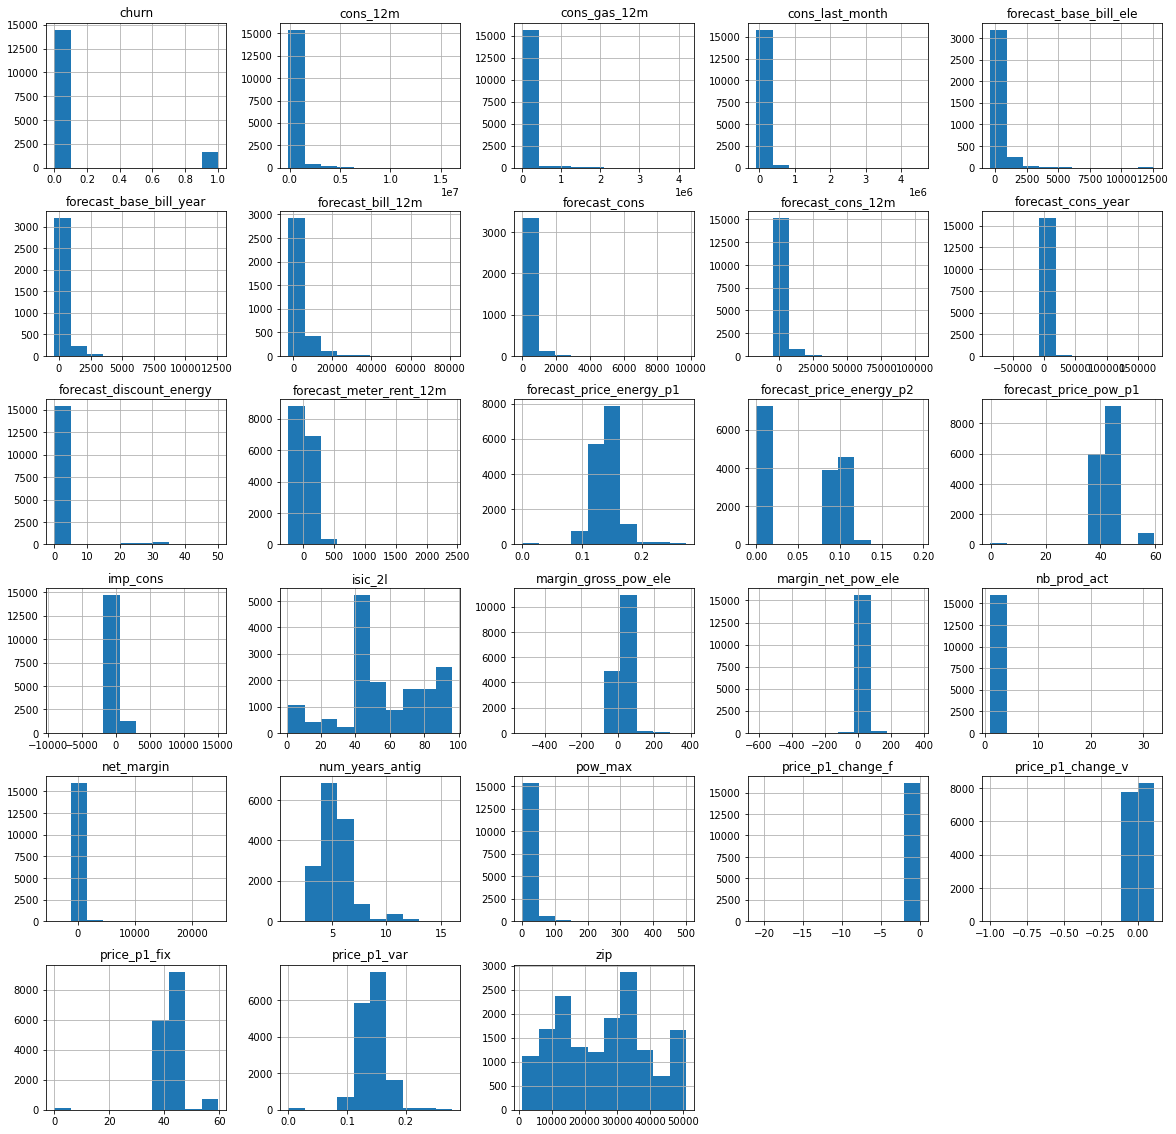

In [ ]:
# plotting the variable distribution
df.hist(figsize = (20,20))
plt.show()

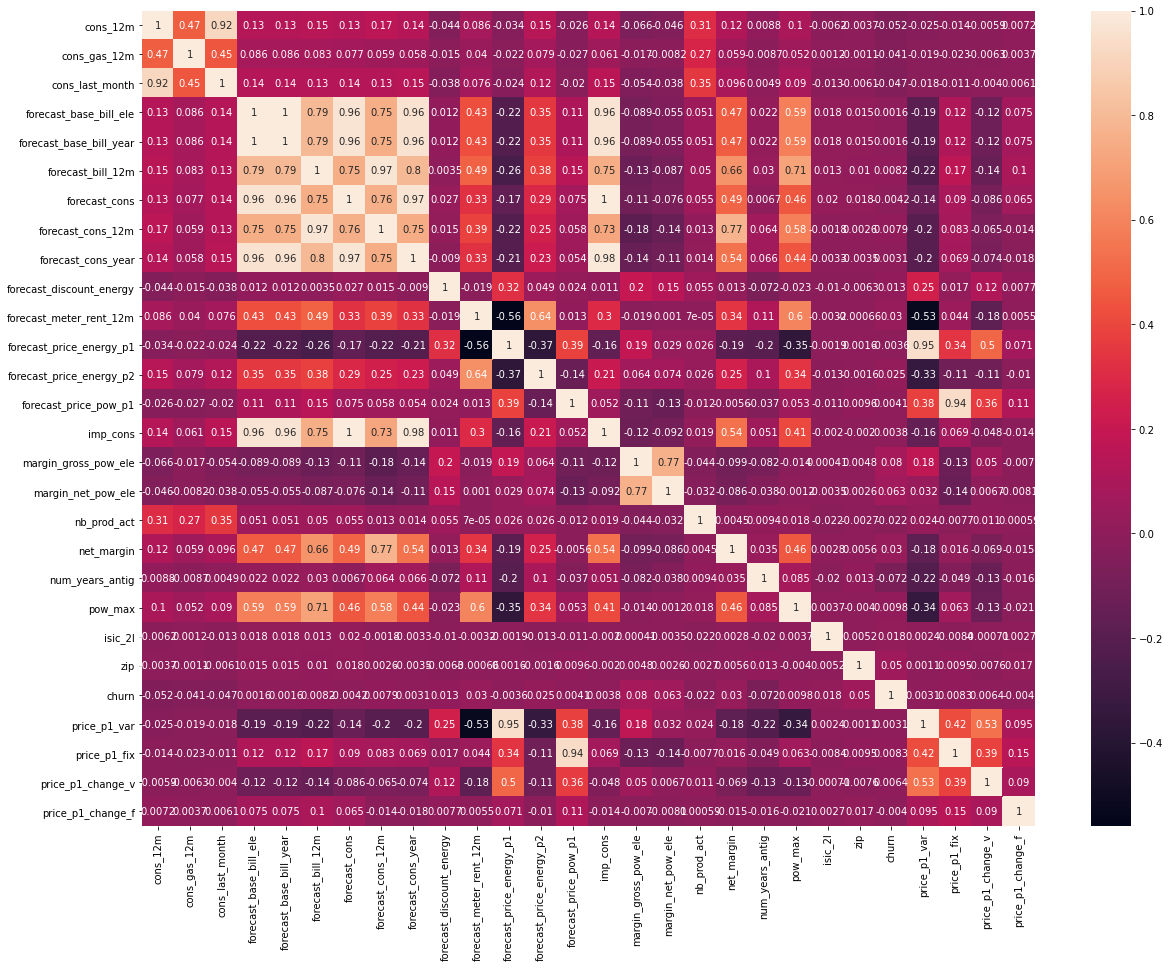

In [ ]:
# correlation between variables (we need to look at continious variables)
corrMatrix = df.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
# Indentifying the classes size
df.churn.value_counts()

0    14495
1     1588
Name: churn, dtype: int64

We have observed the provided data, checking data formats, variable distributions and the correlation matrix. Final initial observation was made to understand the nature of the classification problem for the dataset: unbalanced data. This finding is going to be used further in the analysis.

### Feature Engineering

In [ ]:
# dropping highly correlated columns, leaving only 1 forecast variable: forecast_cons_12m
df = df.drop(
    columns=['forecast_base_bill_ele', 'forecast_base_bill_year', 'forecast_bill_12m', 'forecast_cons', 'forecast_cons_year']
)

# adding duration variables to drop dates for future modelling
df['client_duration'] = (df['date_end'] - df['date_activ']).dt.days
df['contract_duration'] = (df['date_renewal'] - df['date_activ']).dt.days
df['contract_change'] = (df['date_modif_prod'] - df['date_activ']).dt.days
df['modif_duration'] = (df['date_end'] - df['date_modif_prod']).dt.days

# adding the timing of contract ending
df['end_year'] = df['date_end'].dt.year
df['end_month'] = df['date_end'].dt.month
df['end_day'] = df['date_end'].dt.day

# dropping date varialbes due to their incompetability with the model
df = df.drop(columns= ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'])

# dropping a couple of rows where the duration is not defined
df = df.loc[df['client_duration'].isnull() == False]

# visual display
df.head()

,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,...,price_p1_fix,price_p1_change_v,price_p1_change_f,client_duration,contract_duration,contract_change,modif_duration,end_year,end_month,end_day
id,,,,,,,,,,,,,,,,,,,,,
48ada52261e7cf58715202705a0451c9,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,26520.30,0.0,359.29,0.095919,0.088347,58.995952,...,58.956502,-0.036464,0.027507,1460.0,1097.0,0.0,1460.0,2016.0,11.0,6.0
24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0.0,1.78,0.114481,0.098142,40.606701,...,40.640023,-0.017844,-0.006938,1096.0,738.0,NaN,NaN,2016.0,6.0,15.0
23f9e0bddadb1d9c567b3c4576c8ac34,NaN,35446,0,4265,601.51,NaN,20.23,NaN,NaN,NaN,...,44.629894,0.000430,0.003766,2556.0,2193.0,0.0,2556.0,2016.0,10.0,25.0
0c14a4e90623d74951da665862147606,foosdfpfkusacimwkcsosbicdxkicaua,63442,0,10261,1915.14,0.0,20.14,0.143166,0.000000,44.311378,...,44.370635,-0.001412,0.000001,1461.0,1098.0,0.0,1461.0,2016.0,5.0,15.0
f2c6ef2fa0b1a52d02872832279081c0,ewpakwlliwisiwduibdlfmalxowmwpci,11354,0,992,993.85,0.0,132.16,0.106523,0.097482,58.995952,...,58.936778,-0.008294,0.037254,1461.0,1096.0,0.0,1461.0,2017.0,1.0,1.0


### Imputation of Null values

In [ ]:
# impute channel and origin with hand coded variables
df.loc[df["channel_sales"].isnull(), "channel_sales"] = 'Other'
df.loc[df["origin_up"].isnull(), "origin_up"] = 'No sub'

# keeping only origins that appear in the test set
df = df.loc[
    (df['origin_up']=='kamkkxfxxuwbdslkwifmmcsiusiuosws') | 
    (df['origin_up']=='ldkssxwpmemidmecebumciepifcamkci') | 
    (df['origin_up']=='No sub') |
    (df['origin_up']=='lxidpiddsbxsbosboudacockeimpuepw'), ]

# imputing null values based on their zip code and industry
df.loc[df["forecast_discount_energy"].isnull(), "forecast_discount_energy"] = df.groupby(["zip", 'isic_1l'])["forecast_discount_energy"].transform("median")
df.loc[df["forecast_price_energy_p1"].isnull(), "forecast_price_energy_p1"] = df.groupby(["zip", 'isic_1l'])["forecast_price_energy_p1"].transform("median")
df.loc[df["forecast_price_energy_p2"].isnull(), "forecast_price_energy_p2"] = df.groupby(["zip", 'isic_1l'])["forecast_price_energy_p2"].transform("median")
df.loc[df["forecast_price_pow_p1"].isnull(), "forecast_price_pow_p1"] = df.groupby(["zip", 'isic_1l'])["forecast_price_pow_p1"].transform("median")
df.loc[df["margin_gross_pow_ele"].isnull(), "margin_gross_pow_ele"] = df.groupby(["zip", 'isic_1l'])["margin_gross_pow_ele"].transform("median")
df.loc[df["margin_net_pow_ele"].isnull(), "margin_net_pow_ele"] = df.groupby(["zip", 'isic_1l'])["margin_net_pow_ele"].transform("median")
df.loc[df["net_margin"].isnull(), "net_margin"] = df.groupby(["zip", 'isic_1l'])["net_margin"].transform("median")
df.loc[df["contract_duration"].isnull(), "contract_duration"] = df.groupby(["zip", 'isic_1l'])["contract_duration"].transform("median")
df.loc[df["contract_change"].isnull(), "contract_change"] = df.groupby(["zip", 'isic_1l'])["contract_change"].transform("median")
df.loc[df["modif_duration"].isnull(), "modif_duration"] = df.groupby(["zip", 'isic_1l'])["modif_duration"].transform("median")

# filling remaining null values with mean
df = df.fillna(df.mean())

# verifying that there are no null values left
print('Remaining null values in the dataset: ', df.isnull().sum().sum())

# visual display
df.head()

Remaining null values in the dataset:  0


,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,...,price_p1_fix,price_p1_change_v,price_p1_change_f,client_duration,contract_duration,contract_change,modif_duration,end_year,end_month,end_day
id,,,,,,,,,,,,,,,,,,,,,
48ada52261e7cf58715202705a0451c9,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,26520.30,0.000000,359.29,0.095919,0.088347,58.995952,...,58.956502,-0.036464,0.027507,1460.0,1097.0,0.0,1460.0,2016.0,11.0,6.0
24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0.000000,1.78,0.114481,0.098142,40.606701,...,40.640023,-0.017844,-0.006938,1096.0,738.0,1464.0,414.0,2016.0,6.0,15.0
23f9e0bddadb1d9c567b3c4576c8ac34,Other,35446,0,4265,601.51,0.988621,20.23,0.135890,0.052949,43.530589,...,44.629894,0.000430,0.003766,2556.0,2193.0,0.0,2556.0,2016.0,10.0,25.0
0c14a4e90623d74951da665862147606,foosdfpfkusacimwkcsosbicdxkicaua,63442,0,10261,1915.14,0.000000,20.14,0.143166,0.000000,44.311378,...,44.370635,-0.001412,0.000001,1461.0,1098.0,0.0,1461.0,2016.0,5.0,15.0
f2c6ef2fa0b1a52d02872832279081c0,ewpakwlliwisiwduibdlfmalxowmwpci,11354,0,992,993.85,0.000000,132.16,0.106523,0.097482,58.995952,...,58.936778,-0.008294,0.037254,1461.0,1096.0,0.0,1461.0,2017.0,1.0,1.0


### Dataset Preparation for Modelling

In [ ]:
# dummifying categorical variables
df = pd.get_dummies(df)

# identifying independent and target variables in the dataset
X = df.loc[:, df.columns != 'churn']
y = df['churn']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# oversampling the train part
# not many data points to train in --> better getting more data
# RandomOverSampler proved to perform better than SMOTE and BorderlineSMOTE
ros = RandomOverSampler(random_state=42)
ros.fit(X_train, y_train)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

### Modelling

We could start the modelling process with the random forest classifier, the model that proved to work well with classification problems without any major tuning.

In [ ]:
# defining Random Forest Classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_resampled, y_resampled)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
# predictions with the set threshold
y_pred_v = (rf.predict_proba(X_test)[:,1] >= 0.27).astype(bool) # best threshold according to graphs below

# churn propensity
y_pred_p = rf.predict_proba(X_test)[:, 1]

print('AUC score: ', roc_auc_score(y_test, y_pred_p))

AUC score:  0.7426749667076346


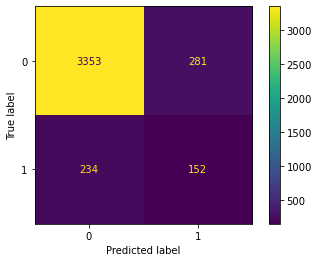

In [ ]:
# confusion matrix with threshold evaluation
cm = confusion_matrix(y_test, 
                      y_pred_v,
                      labels=y_test.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=y_test.unique())
disp.plot() 

---

#### Evaluation Function Definition

In [ ]:
# precision recall and threshold definition
p, r, thresholds = precision_recall_curve(y_test, y_pred_p)

def adjusted_classes(y_pred_p, t):
    """
    This function adjusts class predictions based on the prediction threshold t.
    """
    return [1 if y >= t else 0 for y in y_pred_p]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold t.
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_pred_p, t)
    print('Confusion Matrix')
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.1, 1.01]); ## start at 0.5
    plt.xlim([0.1, 1.01]); ## start at 0.5
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

def plot_precision_recall_vs_threshold(precision, recall, threshold):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precision[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

---

Confusion Matrix
     pred_neg  pred_pos
neg      3353       281
pos       234       152


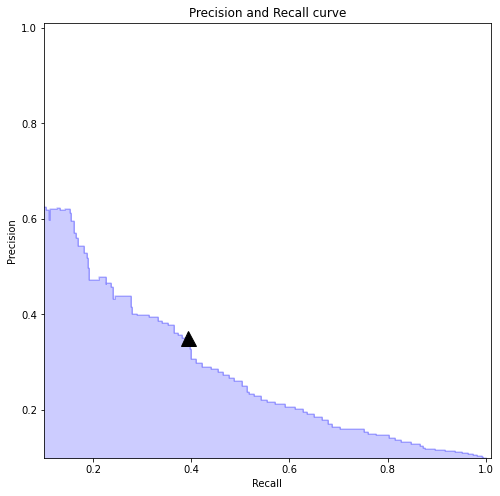

In [ ]:
# sensitivity analysis for the threshold
precision_recall_threshold(p, r, thresholds, 0.27)

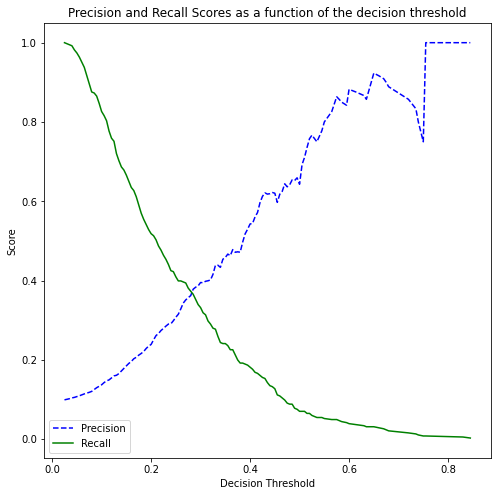

In [ ]:
# precision vs recall plot
plot_precision_recall_vs_threshold(p, r, thresholds)

In [ ]:
# F1 score
f1_score(y_test, y_pred_v)

0.37118437118437114

AUC score:  0.7426749667076346


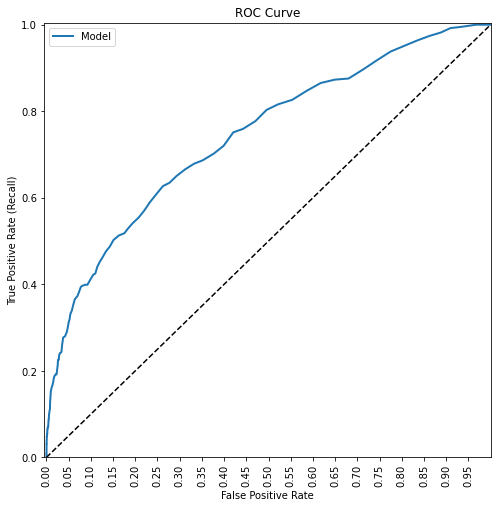

In [ ]:
# plotting ROC curve
fpr, tpr, auc_thresholds = metrics.roc_curve(y_test, y_pred_p)
print('AUC score: ', metrics.auc(fpr, tpr))
plot_roc_curve(fpr, tpr, 'Model')

#### Feature Importance

In [ ]:
# identify most important variables that affect overall classfication
rf_important = pd.Series(rf.feature_importances_, 
                         index=X.columns,)

print('Feature Importance')

# sort importances
df_imp = pd.DataFrame(rf_important.sort_values(ascending=False))
df_imp.columns = ['Feature Importance']

# visual display
df_imp.head(10)

Feature Importance


,Feature Importance
zip,0.092558
margin_net_pow_ele,0.051879
margin_gross_pow_ele,0.048701
cons_12m,0.048115
forecast_meter_rent_12m,0.042431
net_margin,0.040773
price_p1_change_v,0.040044
forecast_cons_12m,0.039983
price_p1_var,0.037993
cons_last_month,0.037926


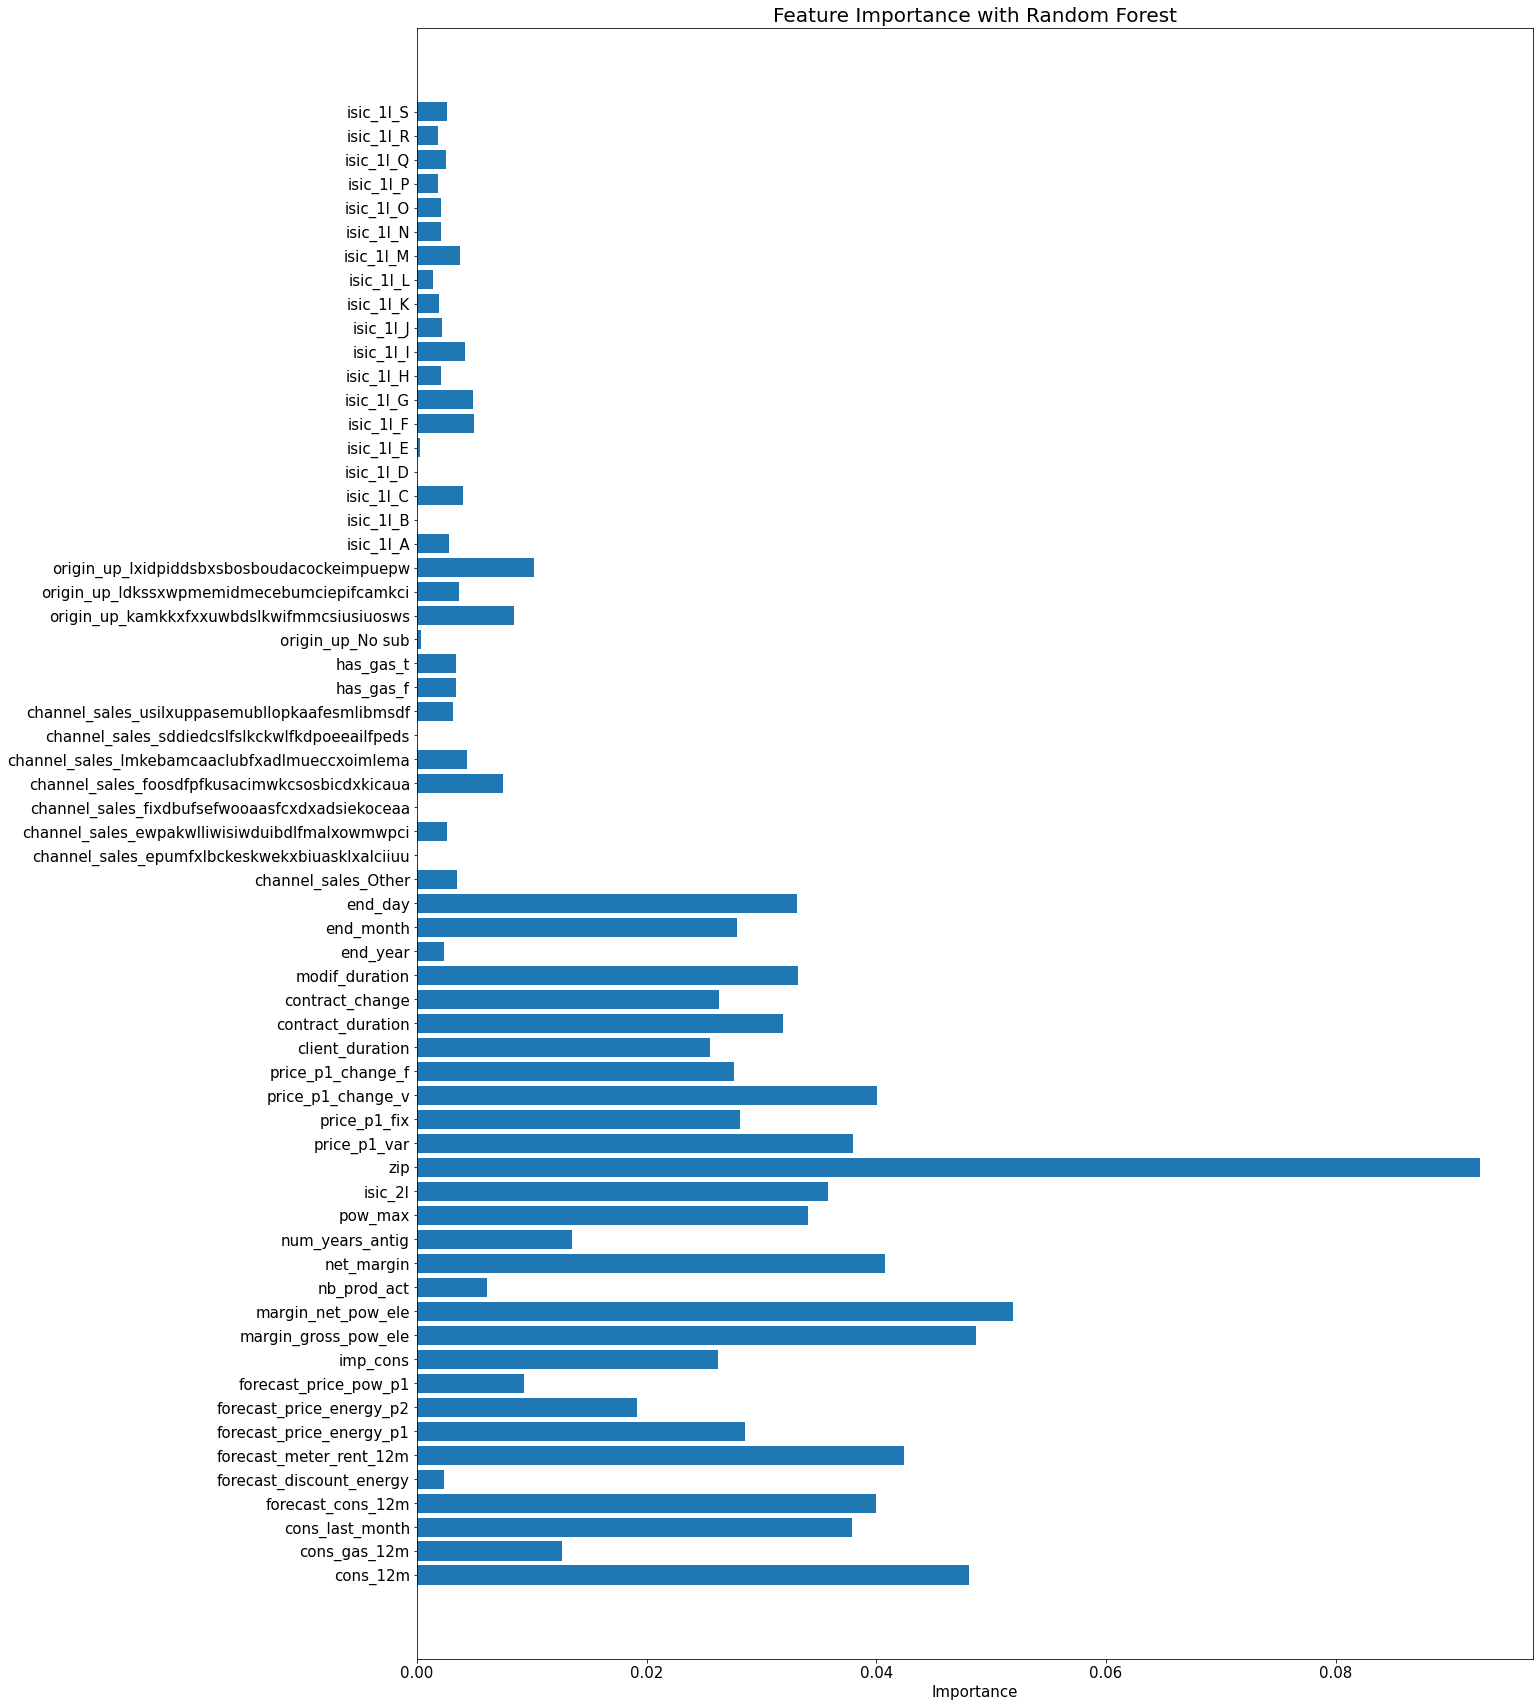

In [ ]:
# plotting feature importances
plt.figure(figsize=(20,30));
plt.barh(X.columns, rf_important);
plt.title("Feature Importance with Random Forest", fontsize=20)
plt.xlabel("Importance",fontsize = 15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

Even though the initial model showed a reasonable performance, we decided to check other models as well. SVM did not perform well whereas hybrid xgboost and random forest approach seemed to be a good choice. The parameters that are remaining in the model were chosen by trial and error.

In [ ]:
# xgbrf classifier with some specified parameters
xgb = xgboost.XGBRFClassifier(verbosity=1, n_estimators=600, random_state=42, learning_rate=0.08, max_depth=8, scale_pos_weight = 0.8, objective= "binary:logistic")
xgb.fit(X_resampled, y_resampled)

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.08,
                max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=600, n_jobs=0,
                num_parallel_tree=600, objective='binary:logistic',
                random_state=42, reg_alpha=0, scale_pos_weight=0.8,
                tree_method='exact', validate_parameters=1, verbosity=1)

In [ ]:
# predictions with the set threshold
y_pred_v = (xgb.predict_proba(X_test)[:,1] >= 0.5).astype(bool)

# churn propensity
y_pred_p = xgb.predict_proba(X_test)[:, 1]

print('AUC score: ', roc_auc_score(y_test, y_pred_p))

AUC score:  0.7452827498495784


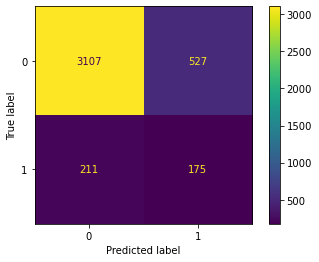

In [ ]:
# confusion matrix with threshold evaluation
cm = confusion_matrix(y_test, 
                      y_pred_v,
                      labels=y_test.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=y_test.unique())
disp.plot()

Confusion Matrix
     pred_neg  pred_pos
neg      3107       527
pos       211       175


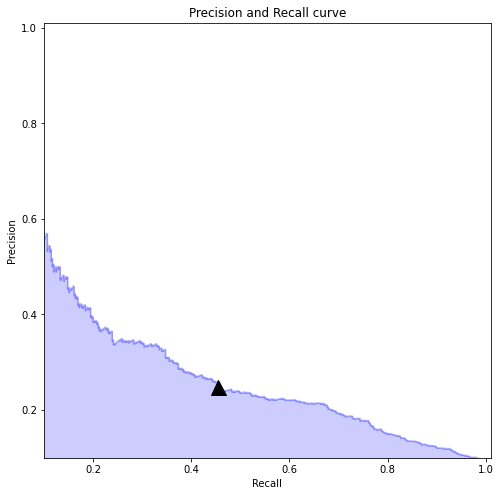

In [ ]:
# precision recall and threshold definition
p, r, thresholds = precision_recall_curve(y_test, y_pred_p)

# sensitivity analysis for the threshold
precision_recall_threshold(p, r, thresholds, 0.5)

In [ ]:
# F1 score
f1_score(y_test, y_pred_v)

0.32169117647058826

AUC score:  0.7452827498495784


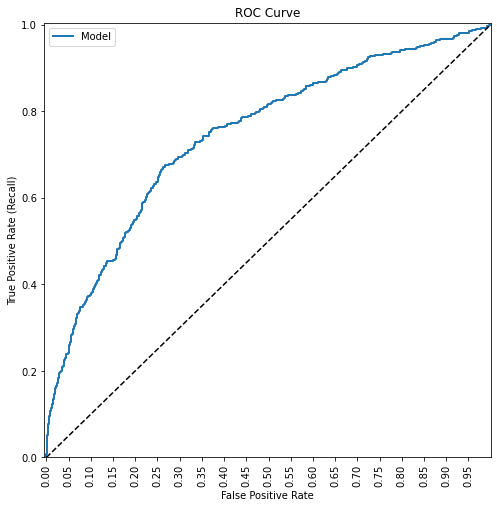

In [ ]:
# plotting ROC curve
fpr, tpr, auc_thresholds = metrics.roc_curve(y_test, y_pred_p)
print('AUC score: ', metrics.auc(fpr, tpr))
plot_roc_curve(fpr, tpr, 'Model')

After several iterations with other models, we understood that random forest gives the best performance and proceeded with hyperparameter tuning.

#### Random Search

In [ ]:
# model pipeline
rf_pipeline = Pipeline(steps = [ ('RF', RandomForestClassifier(random_state=42)) ])

params = {
    'RF__bootstrap':         [True, False],
    'RF__max_depth':         randint(5, 30),
    'RF__max_features':      ['sqrt', 'log2'],
    'RF__min_samples_leaf':  [1, 2, 5, 10],
    'RF__min_samples_split': [2, 3, 5, 10],
    'RF__n_estimators':      randint(30, 1000)
   
}
# establishing a grid search
estimator = RandomizedSearchCV(rf_pipeline, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=4, 
                               #scoring = 'roc_auc' 
                              ) 

estimator.fit(X_resampled, y_resampled)
print("Randomized Search Finished")

Randomized Search Finished


In [ ]:
print("Optimal hyperparameter configuration: ", estimator.best_params_)

Optimal hyperparameter configuration:  {'RF__bootstrap': False, 'RF__max_depth': 29, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 5, 'RF__n_estimators': 341}


#### Optimized Random Forest

In [ ]:
# random forest classifier with optimal hyperparameters
clf = RandomForestClassifier(bootstrap=False, max_depth=29,
                                        max_features='log2',
                                        min_samples_leaf=1,
                                        min_samples_split=5, 
                                        n_estimators=341,
                                        random_state=42)
clf.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=False, max_depth=29, max_features='log2',
                       min_samples_split=5, n_estimators=341, random_state=42)

In [ ]:
# predictions with the set threshold
y_pred_v = (clf.predict_proba(X_test)[:,1] >= 0.2).astype(bool) # best threshold according to graphs below

# churn propensity
y_pred_p = clf.predict_proba(X_test)[:, 1]

print('AUC score: ', roc_auc_score(y_test, y_pred_p))

AUC score:  0.7471188202383363


In [ ]:
y_pred_p

array([0.09564656, 0.04868441, 0.07038123, ..., 0.03812317, 0.09384164,
       0.03519062])

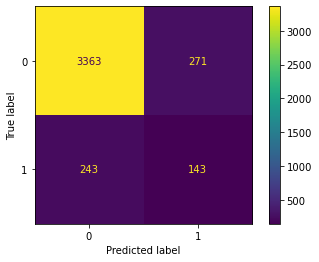

In [ ]:
# confusion matrix with threshold evaluation
cm = confusion_matrix(y_test, 
                      y_pred_v,
                      labels=y_test.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=y_test.unique())
disp.plot()

Confusion Matrix
     pred_neg  pred_pos
neg      3363       271
pos       243       143


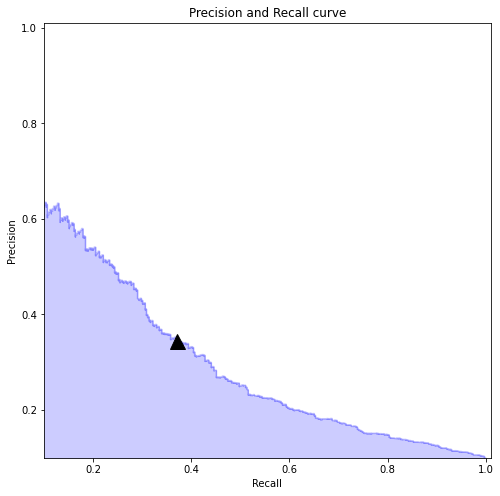

In [ ]:
# precision recall and threshold definition
p, r, thresholds = precision_recall_curve(y_test, y_pred_p)

# sensitivity analysis for the threshold
precision_recall_threshold(p, r, thresholds, 0.2)

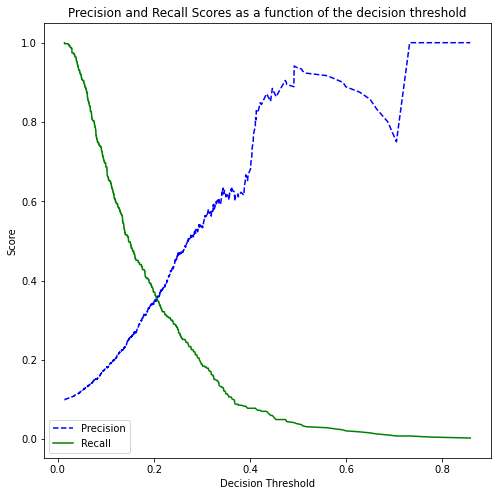

In [ ]:
# precision vs recall plot
plot_precision_recall_vs_threshold(p, r, thresholds)

In [ ]:
# F1 score
f1_score(y_test, y_pred_v)

0.3575

AUC score:  0.7471188202383363


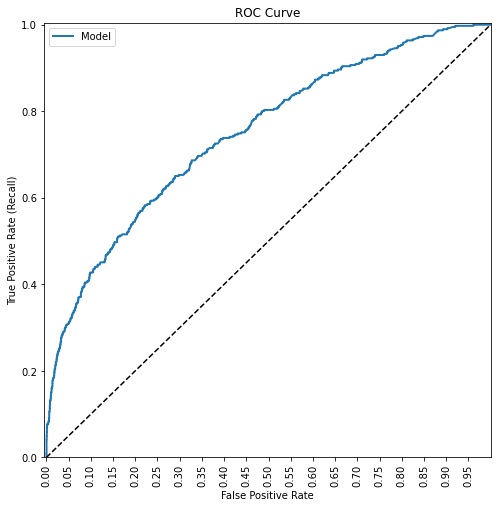

In [ ]:
# plotting ROC curve
fpr, tpr, auc_thresholds = metrics.roc_curve(y_test, y_pred_p)
print('AUC score: ', metrics.auc(fpr, tpr))
plot_roc_curve(fpr, tpr, 'Model')

### Model Application to Train (Probably Excel)

Apply the model towards the train dataset to perform financial analysis (done in excel).

In [ ]:
# training value churn prediction with the set threshold
pred_trv = (clf.predict_proba(X)[:,1] >= 0.2).astype(bool).astype(int)
tr_v = pd.DataFrame(pred_trv)
tr_v.index = X.index
tr_v.columns = ['Churn_prediction']

# training probability churn prediction
pred_trp = clf.predict_proba(X)[:, 1]
tr_p = pd.DataFrame(pred_trp)
tr_p.index = X.index
tr_p.columns = ['Churn_probability']

# saving the dataframe
tr = pd.merge(tr_v, tr_p, left_index=True, right_index=True)
tr
#tr.to_csv('submission.csv')

,Churn_prediction,Churn_probability
id,,
48ada52261e7cf58715202705a0451c9,1,0.216683
24011ae4ebbe3035111d65fa7c15bc57,1,0.999117
23f9e0bddadb1d9c567b3c4576c8ac34,0,0.002409
0c14a4e90623d74951da665862147606,0,0.060734
f2c6ef2fa0b1a52d02872832279081c0,0,0.002199
...,...,...
dd4e5b2dd42cefaa19cfd74f55baf5d1,0,0.000753
40483e460b837001802f82213fd7f763,0,0.002605
ecb635942dbd100f44215ea66b7c3a83,0,0.055034


### Test Data Import

In [ ]:
# importing and preparing test SME dataset
df4 = pd.read_csv('Test_SME_data.csv', index_col=['id'], parse_dates = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'])
df4 = df4.drop(columns=['Unnamed: 0', 'campaign_disc_ele', 'date_first_activ'])

# visual display
df4.head()

,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_base_bill_ele,forecast_base_bill_year,...,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,isic_1l,isic_2l,zip
id,,,,,,,,,,,,,,,,,,,,,
f5ce04411fcb8ea5fbdcc515d818ea01,lmkebamcaaclubfxadlmueccxoimlema,143112,0,0,2012-04-24,2016-04-24,2012-04-24,2015-04-26,NaN,NaN,...,19.28,19.28,1,1795.34,4,ldkssxwpmemidmecebumciepifcamkci,10.392,Q,87,31395
cb3f6adabceb7ea2d6042e85113d6675,NaN,12565,6157,571,2009-09-28,2016-09-28,2015-11-20,2015-09-29,NaN,NaN,...,8.98,8.98,3,77.27,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,10.392,G,47,31395
af0865bfba4e9bd4a60b5a45643109ba,foosdfpfkusacimwkcsosbicdxkicaua,5640,106717,0,2009-11-24,2016-11-24,2009-11-24,2015-11-25,NaN,NaN,...,21.78,21.78,2,82.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,M,72,50316
2623687b9b38dd32aabbefdd0e950f30,foosdfpfkusacimwkcsosbicdxkicaua,48864,0,3190,2012-01-04,2017-01-04,2015-05-24,2016-01-05,NaN,NaN,...,51.84,51.84,1,449.03,4,lxidpiddsbxsbosboudacockeimpuepw,34.641,F,41,15325
ea33a17335d0ef40b27c663dd568d210,NaN,13087,0,1043,2008-01-29,2016-01-29,2008-01-29,2015-02-09,NaN,NaN,...,34.44,34.44,1,146.00,8,ldkssxwpmemidmecebumciepifcamkci,17.240,C,25,20749


In [ ]:
# importing and preparing price dataset 
df5 = pd.read_csv('Test_PRICE_hist.csv', index_col='id')

# adding percentage change of price for each month
df5['price_p1_change_v'] = df5['price_p1_var'].pct_change()
df5['price_p2_change_v'] = df5['price_p2_var'].pct_change()
df5['price_p3_change_v'] = df5['price_p3_var'].pct_change()
df5['price_p1_change_f'] = df5['price_p1_fix'].pct_change()
df5['price_p2_change_f'] = df5['price_p2_fix'].pct_change()
df5['price_p3_change_f'] = df5['price_p3_fix'].pct_change()

# getting rid of inappropriate values: infinit and big ints (ids are going one after the other). 
# N/A imputation is also not ruining the mean estimates in the analysis further below
df5.loc[df5['price_p1_change_f']>1, 'price_p1_change_f'] = np.nan
df5.loc[df5['price_p1_change_v']>1, 'price_p1_change_v'] = np.nan

# visual display
df5.head()

,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,price_p1_change_v,price_p2_change_v,price_p3_change_v,price_p1_change_f,price_p2_change_f,price_p3_change_f
id,,,,,,,,,,,,,
3acc714fbd9b3ccaac3c412cf220e929,2015-01-01,0.168185,0.084213,0.0,44.266931,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3acc714fbd9b3ccaac3c412cf220e929,2015-02-01,0.168185,0.084213,0.0,44.266931,0.0,0.0,0.0,0.0,NaN,0.000000e+00,NaN,NaN
3acc714fbd9b3ccaac3c412cf220e929,2015-03-01,0.168185,0.084213,0.0,44.266931,0.0,0.0,0.0,0.0,NaN,0.000000e+00,NaN,NaN
3acc714fbd9b3ccaac3c412cf220e929,2015-04-01,0.168185,0.084213,0.0,44.266931,0.0,0.0,0.0,0.0,NaN,0.000000e+00,NaN,NaN
3acc714fbd9b3ccaac3c412cf220e929,2015-05-01,0.168185,0.084213,0.0,44.266930,0.0,0.0,0.0,0.0,NaN,-2.710827e-08,NaN,NaN


In [ ]:
# transforming dataset into aggregated values for each client id
df_price_test = df5.groupby(df5.index)['price_p1_var', 'price_p1_fix','price_p1_change_v', 'price_p1_change_f',].mean()

# visual display
df_price_test.head()

<ipython-input-140-cbea2a8577c7>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_price_test = df5.groupby(df5.index)['price_p1_var', 'price_p1_fix','price_p1_change_v', 'price_p1_change_f',].mean()


,price_p1_var,price_p1_fix,price_p1_change_v,price_p1_change_f
id,,,,
000381698491fec6983d55828fe5ada6,0.101811,59.055122,-0.014867,0.037589
000861c9aa2a0784b8d83f8b5b95d010,0.124524,40.661003,-0.014647,-0.006938
0032d340d01dce810b28c3e2a5446fcc,0.124174,40.688156,0.005698,0.000001
004a743cb630d0540d8016fc6c898786,0.151425,44.444710,0.002379,0.000000
007d5d9fbd142235658fe836cfd338fa,0.122726,40.633851,-0.003413,0.000001


In [ ]:
# checking if the index is unique
df_price_test.index.is_unique

True

In [ ]:
# importing churn test template
df6 = pd.read_csv('Test_OUTPUT_template.csv', index_col='id')
df6 = df6.drop(columns=['Unnamed: 0'])
# visual display
df6.head()

,Churn_prediction,Churn_probability
id,,
ed18c9981ce183ef347246cdcc55f743,NaN,NaN
9c341e73685fcff6e3527ebd51da3fe5,NaN,NaN
97dd64b33716aadc4e22c4ab85d1c7a4,NaN,NaN
cf81de72ff7997ed10729751059cf7a3,NaN,NaN
c7c8ee9daf2a864d159d45a2373ada72,NaN,NaN


In [ ]:
# merging datasets
df_test = pd.merge(df4, df_price_test, left_index=True, right_index=True)

# visual display
df_test.head()

,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_base_bill_ele,forecast_base_bill_year,...,num_years_antig,origin_up,pow_max,isic_1l,isic_2l,zip,price_p1_var,price_p1_fix,price_p1_change_v,price_p1_change_f
id,,,,,,,,,,,,,,,,,,,,,
f5ce04411fcb8ea5fbdcc515d818ea01,lmkebamcaaclubfxadlmueccxoimlema,143112,0,0,2012-04-24,2016-04-24,2012-04-24,2015-04-26,NaN,NaN,...,4,ldkssxwpmemidmecebumciepifcamkci,10.392,Q,87,31395,0.147316,44.385450,0.021479,7.573691e-03
cb3f6adabceb7ea2d6042e85113d6675,NaN,12565,6157,571,2009-09-28,2016-09-28,2015-11-20,2015-09-29,NaN,NaN,...,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,10.392,G,47,31395,0.165938,44.311375,0.028224,7.937428e-03
af0865bfba4e9bd4a60b5a45643109ba,foosdfpfkusacimwkcsosbicdxkicaua,5640,106717,0,2009-11-24,2016-11-24,2009-11-24,2015-11-25,NaN,NaN,...,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,M,72,50316,0.149865,44.406745,0.003100,3.158453e-03
2623687b9b38dd32aabbefdd0e950f30,foosdfpfkusacimwkcsosbicdxkicaua,48864,0,3190,2012-01-04,2017-01-04,2015-05-24,2016-01-05,NaN,NaN,...,4,lxidpiddsbxsbosboudacockeimpuepw,34.641,F,41,15325,0.125304,40.565971,0.005129,-3.333261e-04
ea33a17335d0ef40b27c663dd568d210,NaN,13087,0,1043,2008-01-29,2016-01-29,2008-01-29,2015-02-09,NaN,NaN,...,8,ldkssxwpmemidmecebumciepifcamkci,17.240,C,25,20749,0.124041,40.565971,-0.002174,6.568820e-16


In [ ]:
# indentifying variables data types
df_test.dtypes

channel_sales                       object
cons_12m                             int64
cons_gas_12m                         int64
cons_last_month                      int64
date_activ                  datetime64[ns]
date_end                    datetime64[ns]
date_modif_prod             datetime64[ns]
date_renewal                datetime64[ns]
forecast_base_bill_ele             float64
forecast_base_bill_year            float64
forecast_bill_12m                  float64
forecast_cons                      float64
forecast_cons_12m                  float64
forecast_cons_year                   int64
forecast_discount_energy           float64
forecast_meter_rent_12m            float64
forecast_price_energy_p1           float64
forecast_price_energy_p2           float64
forecast_price_pow_p1              float64
has_gas                             object
imp_cons                           float64
margin_gross_pow_ele               float64
margin_net_pow_ele                 float64
nb_prod_act

In [ ]:
# checking the customer id uniqueness
df_test.index.is_unique

True

In [ ]:
# printing all columns the dataset contains
df_test.columns.to_list()

['channel_sales',
 'cons_12m',
 'cons_gas_12m',
 'cons_last_month',
 'date_activ',
 'date_end',
 'date_modif_prod',
 'date_renewal',
 'forecast_base_bill_ele',
 'forecast_base_bill_year',
 'forecast_bill_12m',
 'forecast_cons',
 'forecast_cons_12m',
 'forecast_cons_year',
 'forecast_discount_energy',
 'forecast_meter_rent_12m',
 'forecast_price_energy_p1',
 'forecast_price_energy_p2',
 'forecast_price_pow_p1',
 'has_gas',
 'imp_cons',
 'margin_gross_pow_ele',
 'margin_net_pow_ele',
 'nb_prod_act',
 'net_margin',
 'num_years_antig',
 'origin_up',
 'pow_max',
 'isic_1l',
 'isic_2l',
 'zip',
 'price_p1_var',
 'price_p1_fix',
 'price_p1_change_v',
 'price_p1_change_f']

### Test Transformations

In [ ]:
# performing same feature engineering as in the train dataset
df_test = df_test.drop(
    columns=['forecast_base_bill_ele', 'forecast_base_bill_year', 'forecast_bill_12m', 'forecast_cons', 'forecast_cons_year']
)

# adding duration variables to drop dates
df_test['client_duration'] = (df_test['date_end'] - df_test['date_activ']).dt.days
df_test['contract_duration'] = (df_test['date_renewal'] - df_test['date_activ']).dt.days
df_test['contract_change'] = (df_test['date_modif_prod'] - df_test['date_activ']).dt.days
df_test['modif_duration'] = (df_test['date_end'] - df_test['date_modif_prod']).dt.days

# adding the timing of contract ending
df_test['end_year'] = df_test['date_end'].dt.year
df_test['end_month'] = df_test['date_end'].dt.month
df_test['end_day'] = df_test['date_end'].dt.day

# dropping date varialbes due to their incompetability with the model
df_test = df_test.drop(columns= ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'])

# visual display
df_test.head()

,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,...,price_p1_fix,price_p1_change_v,price_p1_change_f,client_duration,contract_duration,contract_change,modif_duration,end_year,end_month,end_day
id,,,,,,,,,,,,,,,,,,,,,
f5ce04411fcb8ea5fbdcc515d818ea01,lmkebamcaaclubfxadlmueccxoimlema,143112,0,0,21109.24,0.0,64.09,0.142819,0.000000,44.311378,...,44.385450,0.021479,7.573691e-03,1461,1097.0,0.0,1461.0,2016,4,24
cb3f6adabceb7ea2d6042e85113d6675,NaN,12565,6157,571,812.64,0.0,13.87,0.160590,0.083332,44.311378,...,44.311375,0.028224,7.937428e-03,2557,2192.0,2244.0,313.0,2016,9,28
af0865bfba4e9bd4a60b5a45643109ba,foosdfpfkusacimwkcsosbicdxkicaua,5640,106717,0,848.04,0.0,19.44,0.146348,0.000000,45.806878,...,44.406745,0.003100,3.158453e-03,2557,2192.0,0.0,2557.0,2016,11,24
2623687b9b38dd32aabbefdd0e950f30,foosdfpfkusacimwkcsosbicdxkicaua,48864,0,3190,3706.53,0.0,129.71,0.117488,0.100598,40.606701,...,40.565971,0.005129,-3.333261e-04,1827,1462.0,1236.0,591.0,2017,1,4
ea33a17335d0ef40b27c663dd568d210,NaN,13087,0,1043,1406.14,0.0,132.46,0.116900,0.100015,40.606701,...,40.565971,-0.002174,6.568820e-16,2922,2568.0,0.0,2922.0,2016,1,29


In [ ]:
# performing same imputation as in the test dataset
df_test.loc[df_test["channel_sales"].isnull(), "channel_sales"] = 'Other'
df_test.loc[df_test["origin_up"].isnull(), "origin_up"] = 'No sub'

df_test = df_test.loc[
    (df_test['origin_up']=='kamkkxfxxuwbdslkwifmmcsiusiuosws') | 
    (df_test['origin_up']=='ldkssxwpmemidmecebumciepifcamkci') | 
    (df_test['origin_up']=='No sub') |
    (df_test['origin_up']=='lxidpiddsbxsbosboudacockeimpuepw'), ]

# imputing null values based on their zip code and industry
df_test.loc[df_test["forecast_discount_energy"].isnull(), "forecast_discount_energy"] = df_test.groupby(["zip", 'isic_1l'])["forecast_discount_energy"].transform("median")
df_test.loc[df_test["forecast_price_energy_p1"].isnull(), "forecast_price_energy_p1"] = df_test.groupby(["zip", 'isic_1l'])["forecast_price_energy_p1"].transform("median")
df_test.loc[df_test["forecast_price_energy_p2"].isnull(), "forecast_price_energy_p2"] = df_test.groupby(["zip", 'isic_1l'])["forecast_price_energy_p2"].transform("median")
df_test.loc[df_test["forecast_price_pow_p1"].isnull(), "forecast_price_pow_p1"] = df_test.groupby(["zip", 'isic_1l'])["forecast_price_pow_p1"].transform("median")
df_test.loc[df_test["margin_gross_pow_ele"].isnull(), "margin_gross_pow_ele"] = df_test.groupby(["zip", 'isic_1l'])["margin_gross_pow_ele"].transform("median")
df_test.loc[df_test["margin_net_pow_ele"].isnull(), "margin_net_pow_ele"] = df_test.groupby(["zip", 'isic_1l'])["margin_net_pow_ele"].transform("median")
df_test.loc[df_test["net_margin"].isnull(), "net_margin"] = df_test.groupby(["zip", 'isic_1l'])["net_margin"].transform("median")
df_test.loc[df_test["contract_duration"].isnull(), "contract_duration"] = df_test.groupby(["zip", 'isic_1l'])["contract_duration"].transform("median")
df_test.loc[df_test["contract_change"].isnull(), "contract_change"] = df_test.groupby(["zip", 'isic_1l'])["contract_change"].transform("median")
df_test.loc[df_test["modif_duration"].isnull(), "modif_duration"] = df_test.groupby(["zip", 'isic_1l'])["modif_duration"].transform("median")

# filling remaining null values with mean
df_test = df_test.fillna(df_test.mean())

# verifying that there are no null values left
print('Remaining null values in the dataset: ', df_test.isnull().sum().sum())

# visual display
df_test.head()

Remaining null values in the dataset:  0


,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,...,price_p1_fix,price_p1_change_v,price_p1_change_f,client_duration,contract_duration,contract_change,modif_duration,end_year,end_month,end_day
id,,,,,,,,,,,,,,,,,,,,,
f5ce04411fcb8ea5fbdcc515d818ea01,lmkebamcaaclubfxadlmueccxoimlema,143112,0,0,21109.24,0.0,64.09,0.142819,0.000000,44.311378,...,44.385450,0.021479,7.573691e-03,1461,1097.0,0.0,1461.0,2016,4,24
cb3f6adabceb7ea2d6042e85113d6675,Other,12565,6157,571,812.64,0.0,13.87,0.160590,0.083332,44.311378,...,44.311375,0.028224,7.937428e-03,2557,2192.0,2244.0,313.0,2016,9,28
af0865bfba4e9bd4a60b5a45643109ba,foosdfpfkusacimwkcsosbicdxkicaua,5640,106717,0,848.04,0.0,19.44,0.146348,0.000000,45.806878,...,44.406745,0.003100,3.158453e-03,2557,2192.0,0.0,2557.0,2016,11,24
2623687b9b38dd32aabbefdd0e950f30,foosdfpfkusacimwkcsosbicdxkicaua,48864,0,3190,3706.53,0.0,129.71,0.117488,0.100598,40.606701,...,40.565971,0.005129,-3.333261e-04,1827,1462.0,1236.0,591.0,2017,1,4
ea33a17335d0ef40b27c663dd568d210,Other,13087,0,1043,1406.14,0.0,132.46,0.116900,0.100015,40.606701,...,40.565971,-0.002174,6.568820e-16,2922,2568.0,0.0,2922.0,2016,1,29


In [ ]:
# dummifying categorical variables
df_test = pd.get_dummies(df_test)

In [ ]:
pred_v = (clf.predict_proba(df_test)[:,1] >= 0.2).astype(bool).astype(int)
sub_v = pd.DataFrame(pred_v)
sub_v.index = df_test.index
sub_v.columns = ['Churn_prediction']

pred_p = clf.predict_proba(df_test)[:, 1]
sub_p = pd.DataFrame(pred_p)
sub_p.index = df_test.index
sub_p.columns = ['Churn_probability']

sub = pd.merge(sub_v, sub_p, left_index=True, right_index=True)
sub
#sub.to_csv('submission.csv')

,Churn_prediction,Churn_probability
id,,
f5ce04411fcb8ea5fbdcc515d818ea01,0,0.108138
cb3f6adabceb7ea2d6042e85113d6675,0,0.053025
af0865bfba4e9bd4a60b5a45643109ba,0,0.063720
2623687b9b38dd32aabbefdd0e950f30,0,0.127644
ea33a17335d0ef40b27c663dd568d210,0,0.058322
...,...,...
31adcf994b5c94953519a51b71e3d24f,0,0.092128
8476d82f9c1870ce35c390d15da48b9f,0,0.117302
504f045a96d0df10120f93b0dc8d8bd7,0,0.061584


In [ ]:
# save predictions in the CSV file
sub.to_csv('submission_test.csv')

## Conslusion

To sum up, we have explored the PowerCo customer information and built a prediction model for future business implications. Please find predictions for the test dataset in the attachment. All finding are going to be translated into the business context to mitigate the churn rate.